# Showcase of the "to_sql" functionality of mlinspect

It will be shown how parts of the original mlinspect example pipelines
"healthcare" and "compas" will be inspected using the additional "to_sql"
functionality.

## Required packages:
See: requirements/requirements.txt and requirements/requirements.dev.txt

## Some parameters you might want to set:

In [1]:
import pathlib
import timeit
from inspect import cleandoc
import matplotlib.pyplot as plt

from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from pandas_connector import PandasConnector
from mlinspect import PipelineInspector
from mlinspect.utils import get_project_root
from _code_as_string import get_healthcare_pipe_code
from pandas_connector import PandasConnector
from _benchmark_utility import plot_compare, ROOT_DIR, PLOT_DIR
from _code_as_string import Join, GroupBy, Selection, Projection

DO_CLEANUP = True
SIZES = [(10 ** i) for i in range(2, 5, 1)]
BENCH_REP = 10
MLINSPECT_ROOT_DIR = get_project_root()

# DBMS related:
UMBRA_DIR = r"/home/luca/Documents/Bachelorarbeit/umbra-students"
UMBRA_USER = "postgres"
UMBRA_PW = " "
UMBRA_DB = ""
UMBRA_PORT = 5433
UMBRA_HOST = "/tmp/"

POSTGRES_USER = "luca"
POSTGRES_PW = "password"
POSTGRES_DB = "healthcare_benchmark"
POSTGRES_PORT = 5432
POSTGRES_HOST = "localhost"

# Data Generation

To be able to benchmark and compare the different approaches, some datasets
will need to be generated before. The datasets are just and expansion of the
original ones.

In [2]:
!{sys.executable} -m pip install faker

from data_generation.compas_data_generation import generate_compas_dataset
from data_generation.healthcare_data_generation import generate_healthcare_dataset

# We only generate the files, that are not already existing:

COMPAS_DATA_PATHS = generate_compas_dataset(SIZES)
HEALTHCARE_DATA_PATHS = generate_healthcare_dataset(SIZES)

/bin/bash: {sys.executable}: command not found
Data generated or found for: size = 100 -- compas
Data generated or found for: size = 1000 -- compas
Data generated or found for: size = 10000 -- compas
Data generated or found for: size = 100 -- healthcare
Data generated or found for: size = 1000 -- healthcare
Data generated or found for: size = 10000 -- healthcare


## Benchmark Inspection:

Running pandas...  -- size 100


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres
2021-07-26 08:50:11.891419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-26 08:50:11.891439: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<connection object at 0x7fda88fc5af0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
Running postgres...  -- size 100


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98e0d3af0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98968d9c0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9897da2a0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9897239c0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98968de80; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989633040; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989639760; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98962ae80; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9895e5c20; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
Running umbra... -- size 100


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989606d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
<connection object at 0x7fd9896013d0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9895a7d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9895a7d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9895da040; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9895659c0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98956a3d0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989584d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989584d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989584d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989545af0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
Running pandas...  -- size 1000


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989545af0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
Running postgres...  -- size 1000


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98941d170; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989224c20; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989250af0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9894f7c20; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98950faf0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9894a8d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9894b53d0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989402d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9894a8e80; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
Running umbra... -- size 1000
<connection object at 0x7fd989434170; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989439af0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98943b500; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989471d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989471d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989473170; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98926baf0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98926baf0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989274e80; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98935dd50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9893242a0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
Running pandas...  -- size 10000


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989328c20; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
Running postgres...  -- size 10000


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9893242a0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989328c20; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9892c7170; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9892afd50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9892db890; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989393e80; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989387d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9893782a0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9893a2c20; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
Running umbra... -- size 10000
<connection object at 0x7fd9893879c0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98923b040; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd9892419c0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98903d3d0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989030d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989030d50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd989035170; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98905baf0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd98905baf0; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd988c6ee80; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7fd988c7ed50; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>


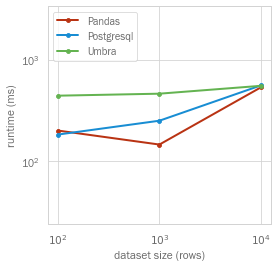

In [3]:
def get_inspection_code_healthcare(pipeline_code, to_sql, dbms_connector, one_run=False):
    setup_code = cleandoc(f"""
from inspect import cleandoc
from mlinspect.utils import get_project_root
from mlinspect import PipelineInspector
from mlinspect.inspections import RowLineage, MaterializeFirstOutputRows
from mlinspect.checks import NoBiasIntroducedFor, NoIllegalFeatures
from demo.feature_overview.no_missing_embeddings import NoMissingEmbeddings
from inspect import cleandoc
from example_pipelines.healthcare import custom_monkeypatching
from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from mlinspect import PipelineInspector

dbms_connector_u = UmbraConnector(dbname=\'{UMBRA_DB}\', user=\'{UMBRA_USER}\', password=\'{UMBRA_PW}\',
    port={UMBRA_PORT}, host=\'{UMBRA_HOST}\', umbra_dir= r\'{UMBRA_DIR}\')
dbms_connector_p = PostgresqlConnector(dbname=\'{POSTGRES_DB}\', user=\'{POSTGRES_USER}\',
    password=\'{POSTGRES_PW}\', port={POSTGRES_PORT}, host=\'{POSTGRES_HOST}\')

pipeline_code = cleandoc(f\"\"\"{pipeline_code}\"\"\")

pipeline_inspector = PipelineInspector.on_pipeline_from_string(pipeline_code) \\
    .add_custom_monkey_patching_module(custom_monkeypatching) \\
    .add_check(NoBiasIntroducedFor([\'age_group\', \'race\'])) \\
    .add_check(NoIllegalFeatures()) \\
    .add_check(NoMissingEmbeddings()) \\
    .add_required_inspection(RowLineage(5)) \\
    .add_required_inspection(MaterializeFirstOutputRows(5))
    """)
    if to_sql:
        return setup_code, f"pipeline_inspector.execute_in_sql(dbms_connector={dbms_connector}, " \
                           f"sql_one_run={one_run}, mode=\'CTE\')"

    return setup_code, f"pipeline_inspector.execute()"


def run(pipeline_code, to_sql=False, dbms_connector=None, one_run=False):
    setup_code, test_code = get_inspection_code_healthcare(pipeline_code, to_sql, dbms_connector, one_run)
    if to_sql:
        result = []
        for i in range(BENCH_REP):
            print(f"run {i} of {BENCH_REP} ...")
            # This special case is necessary to deduct the time for dropping the existing tables and views!
            result.append(timeit.timeit(test_code, setup=setup_code, number=1) * 1000)  # in s
        return sum(result) / BENCH_REP

    return (timeit.timeit(test_code, setup=setup_code, number=BENCH_REP) / BENCH_REP) * 1000  # in s


def pipeline_inspection_benchmark(display_hardware_usage: bool = False):
    pandas_times = []
    postgres_times = []
    umbra_times = []
    for sql_one_run in [False]:
        for i, (path_to_csv_pat, path_to_csv_his) in enumerate(HEALTHCARE_DATA_PATHS):
            setup_code, test_code = get_healthcare_pipe_code(path_to_csv_pat, path_to_csv_his)
            pipe_code = setup_code + "\n" + test_code

            print(f"Running pandas...  -- size {SIZES[i]}")
            pandas_times.append(run(pipe_code, to_sql=False, dbms_connector=None, one_run=sql_one_run))
            print(f"Running postgres...  -- size {SIZES[i]}")
            postgres_times.append(run(pipe_code, to_sql=True, dbms_connector="dbms_connector_p", one_run=sql_one_run))
            print(f"Running umbra... -- size {SIZES[i]}")
            umbra_times.append(run(pipe_code, to_sql=True, dbms_connector="dbms_connector_u", one_run=sql_one_run))

            # sys.argv = ["psrecord", "--duration=100", "--log=activity.txt", "1540"]
            # main()

        names = ["Pandas", "Postgresql", "Umbra"]
        title = "healthcare_pandas_compare"
        table = [pandas_times, postgres_times, umbra_times]
        plot = plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)
        plot.show()

pipeline_inspection_benchmark()


